In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import os
import math
from torch import nn
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt  
import itertools
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## DataLoader

In [2]:
### handle the dataset
class TorchDataset(Dataset):
    def __init__(self, trs_file, label_file, trace_num, trace_offset, trace_length):
        self.trs_file = trs_file
        self.label_file = label_file
        self.trace_num = trace_num
        self.trace_offset = trace_offset
        self.trace_length = trace_length
        self.ToTensor = transforms.ToTensor()
    def __getitem__(self, i):
        index = i % self.trace_num
        trace = self.trs_file[index,:]
        label = self.label_file[index]
        trace = trace[self.trace_offset:self.trace_offset+self.trace_length]
        trace = np.reshape(trace,(1,-1))
        trace = self.ToTensor(trace)
        trace = np.reshape(trace, (1,-1))
        label = torch.tensor(label, dtype=torch.long) 
        return trace.float(), label
    def __len__(self):
        return self.trace_num
    
### data loader for training
def load_training(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
    return train_loader

### data loader for testing
def load_testing(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=1, pin_memory=True)
    return test_loader

## Arrays and Functions

In [3]:
Sbox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71,
        240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216,
        49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160,
        82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208,
        239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188,
        182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96,
        129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211,
        172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186,
        120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97,
        53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140,
        161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22]

HW_byte = [0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2,
            3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2, 2, 3, 2, 3,
            3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3,
            4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4,
            3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5,
            6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4,
            4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5,
            6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8]

### To train a network 
def train(epoch, model):
    """
    - epoch : the current epoch
    - model : the current model
    """
    # Instantiate the iterator
    iter_source = iter(source_train_loader)
    # get the number of batches
    num_iter = len(source_train_loader)
    clf_criterion = nn.CrossEntropyLoss()
    # train on each batch of data
    for i in range(1, num_iter+1):
        source_data, source_label = iter_source.next()
        if cuda:
            source_data, source_label = source_data.cuda(), source_label.cuda()
        source_data, source_label = Variable(source_data), Variable(source_label)
        optimizer.zero_grad()
        _, source_preds = model(source_data)
        preds = source_preds.data.max(1, keepdim=True)[1]
        correct_batch = preds.eq(source_label.data.view_as(preds)).sum()
        loss = clf_criterion(source_preds, source_label)
        # optimzie the cross-entropy loss
        loss.backward()
        optimizer.step()
        if i % log_interval == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}%'.format(
                epoch, i * len(source_data), len(source_train_loader) * batch_size,
                100. * i / len(source_train_loader), loss.data, float(correct_batch) * 100. /batch_size))
            
### validation 
def validation(model):
    """
    - model : the current model
    """    
    # enter evaluation mode
    model.eval()
    valid_loss = 0
    # the number of correct prediction
    correct_valid = 0
    clf_criterion = nn.CrossEntropyLoss()
    for data, label in source_valid_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        _, valid_preds = model(data)
        # sum up batch loss
        valid_loss += clf_criterion(valid_preds, label) 
        # get the index of the max probability
        pred = valid_preds.data.max(1)[1] 
        # get the number of correct prediction
        correct_valid += pred.eq(label.data.view_as(pred)).cpu().sum()
    valid_loss /= len(source_valid_loader)
    valid_acc = 100. * correct_valid / len(source_valid_loader.dataset)
    print('Validation: loss: {:.4f}, accuracy: {}/{} ({:.6f}%)'.format(
        valid_loss.data, correct_valid, len(source_valid_loader.dataset),
        valid_acc))
    return valid_loss, valid_acc

### test/attack
def test(model, device_id, disp_GE=True, model_flag='pretrained'):
    """
    - model : the current model
    - device_id : id of the tested device
    - disp_GE : whether to attack/calculate guessing entropy (GE)
    - model_flag : a string for naming GE result
    """
    # enter evaluation mode
    model.eval()
    test_loss = 0
    # the number of correct prediction
    correct = 0
    epoch = 0
    clf_criterion = nn.CrossEntropyLoss()
    if device_id == source_device_id: # attack on the source domain
        test_num = source_test_num
        test_loader = source_test_loader
        real_key = real_key_01
    else: # attack on the target domain
        test_num = target_test_num
        test_loader = target_test_loader
        real_key = real_key_02
    # Initialize the prediction and label lists(tensors)
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    test_preds_all = torch.zeros((test_num, class_num), dtype=torch.float, device='cpu')
    for data, label in test_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        _, test_preds = model(data)
        # sum up batch loss
        test_loss += clf_criterion(test_preds, label) 
        # get the index of the max probability
        pred = test_preds.data.max(1)[1]
        # get the softmax results for attack/showing guessing entropy
        softmax = nn.Softmax(dim=1)
        test_preds_all[epoch*batch_size:(epoch+1)*batch_size, :] =softmax(test_preds)
        # get the predictions (predlist) and real labels (lbllist) for showing confusion matrix
        predlist=torch.cat([predlist,pred.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        # get the number of correct prediction
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()
        epoch += 1
    test_loss /= len(test_loader)
    print('Target test loss: {:.4f}, Target test accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss.data, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # get the confusion matrix
    confusion_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
    # show the confusion matrix
    plot_confusion_matrix(confusion_mat, classes = range(class_num))
    # show the guessing entropy and success rate
    if disp_GE:
        plot_guessing_entropy(test_preds_all.numpy(), real_key, device_id, model_flag)

### ALPA
def ALPA_train(epoch, atn_model, critic):
    """
    - epoch : the current epoch
    - atn_model: the adversarial transfer network
    - critic: the Discriminator
    """
    # enter training mode
    atn_model.train()
    critic.train()
    # Instantiate the Iterator for source profiling traces
    iter_source = iter(source_train_loader)
    # Instantiate the Iterator for target traces
    iter_target = iter(target_finetune_loader)
    num_iter_target = len(target_finetune_loader)
    finetune_trace_all = torch.zeros((num_iter_target, batch_size, 1, trace_length))
    for i in range(num_iter_target):
        finetune_trace_all[i,:,:,:], _ = iter_target.next()
    # get the number of batches
    num_iter = len(source_train_loader)
    clf_criterion = nn.CrossEntropyLoss()
    # train on each batch of data
    for i in range(1, num_iter+1):
        # get traces and labels for source domain
        source_data, source_label = iter_source.next()
        # get traces for target domain
        target_data = finetune_trace_all[(i-1)%num_iter_target,:,:,:]
        # Instantiate the target Iterator again if all target traces have been used
        if cuda:
            source_data = source_data.cuda()
            source_label = source_label.cuda()
            target_data = target_data.cuda()
        source_data = Variable(source_data)
        target_data = Variable(target_data)
        ############################
        ### Train  Discriminator ###
        ############################
        optimizer_critic.zero_grad()
        # extract and concat features
        feat_s, output_s = atn_model(source_data)
        feat_t, output_t = atn_model(target_data)
        softmax_output_s = nn.Softmax(dim=1)(output_s)
        softmax_output_t = nn.Softmax(dim=1)(output_t)
        op_out_s = torch.bmm(softmax_output_s.unsqueeze(2), feat_s.unsqueeze(1))
        op_out_s = op_out_s.view(-1, softmax_output_s.size(1) * feat_s.size(1))
        op_out_t = torch.bmm(softmax_output_t.unsqueeze(2), feat_t.unsqueeze(1))
        op_out_t = op_out_t.view(-1, softmax_output_t.size(1) * feat_s.size(1))
        feat_concat = torch.cat((op_out_s, op_out_t), 0)

        # predict on discriminator
        pred_concat = critic(feat_concat.detach())
        # prepare domain labels, 1 for source device, 0 for target device
        critic_label_s = Variable((torch.ones(feat_s.size(0)).long()).cuda())
        critic_label_t = Variable((torch.zeros(feat_t.size(0)).long()).cuda())
        critic_label_concat = torch.cat((critic_label_s, critic_label_t), 0)
        # compute loss for critic
        loss_critic = clf_criterion(pred_concat, critic_label_concat)
        loss_critic.backward()
        # optimize critic
        optimizer_critic.step()
        preds = pred_concat.data.max(1, keepdim=True)[1]
        # get the number of correct prediction
        correct_batch = preds.eq(critic_label_concat.data.view_as(preds)).sum()
        
        ############################
        ### Train   the  Encoder ###
        ############################
        # zero gradients for optimizer
        optimizer_model.zero_grad()
        # extract target features
        feat_t, output_t = atn_model(target_data)
        softmax_output_t = nn.Softmax(dim=1)(output_t)
        op_out_t = torch.bmm(softmax_output_t.unsqueeze(2), feat_t.unsqueeze(1))
        op_out_t = op_out_t.view(-1, softmax_output_t.size(1) * feat_t.size(1))
        # predict on discriminator
        pred_t = critic(op_out_t)
        # prepare fake labels
        fake_label_t = Variable((torch.ones(feat_t.size(0)).long()).cuda())
        # compute adversarial discriminator loss 
        loss_tgt = clf_criterion(pred_t, fake_label_t)
        # compute classification loss on source data
        _, pred_s = atn_model(source_data)
        loss_cls_s = clf_criterion(pred_s, source_label)
        total_loss = _lambda*loss_tgt + loss_cls_s
        total_loss.backward()
        # optimize total loss
        optimizer_model.step()
        if i % log_interval == 0:
            print('Epoch {}: [{}/{} ({:.0f}%)]\tcritic_loss: {:.2f}\tencoder_loss: {:.2f}\tsource_cls_loss: {:.2f}\tcritic_acc: {:.2f}'.format(
                epoch, i * len(source_data), len(source_train_loader) * batch_size, 100. * i / len(source_train_loader), loss_critic.data,
                loss_tgt.data, loss_cls_s.data, float(correct_batch) * 100. /(batch_size*2)))

### Validation for ALPA          
def ALPA_validation(atn_model, critic):
    """
    - atn_model: the adversarial transfer network
    - critic: the Discriminator
    """
    # enter evaluation mode
    atn_model.eval()
    critic.eval()
    # Instantiate the Iterator for source traces
    iter_source = iter(source_valid_loader)
    # Instantiate the Iterator for target traces
    iter_target = iter(target_finetune_loader)
    
    num_iter_target = len(target_finetune_loader)
    finetune_trace_all = torch.zeros((num_iter_target, batch_size, 1, trace_length))
    clf_criterion = nn.CrossEntropyLoss()
    for i in range(num_iter_target):
        finetune_trace_all[i,:,:,:], _ = iter_target.next()
    # get the number of batches
    num_iter = len(source_valid_loader)
    # the adversarial discriminator loss 
    total_tgt_loss = 0
    # the classification loss
    total_cls_loss = 0
    for i in range(1, num_iter+1):
        # get traces and labels for source domain
        source_data, source_label = iter_source.next()
        # get traces for target domain
        target_data = finetune_trace_all[(i-1)%num_iter_target,:,:,:]
        # Instantiate the target Iterator again if all target traces have been used
        if cuda:
            source_data = source_data.cuda()
            source_label = source_label.cuda()
            target_data = target_data.cuda()
        source_data = Variable(source_data)
        target_data = Variable(target_data)
        ############################
        # extract and target features
        feat_t, output_t = atn_model(target_data)
        softmax_output_t = nn.Softmax(dim=1)(output_t)
        op_out_t = torch.bmm(softmax_output_t.unsqueeze(2), feat_t.unsqueeze(1))
        op_out_t = op_out_t.view(-1, softmax_output_t.size(1) * feat_t.size(1))
        # predict on discriminator
        pred_t = critic(op_out_t)
        # prepare fake labels
        fake_label_t = Variable((torch.ones(feat_t.size(0)).long()).cuda())
        # compute adversarial discriminator loss 
        total_tgt_loss = total_tgt_loss + nn.CrossEntropyLoss()(pred_t, fake_label_t)
        # compute classification loss on source data
        _, pred_s = atn_model(source_data)
        total_cls_loss = total_cls_loss + clf_criterion(pred_s, source_label)
    total_tgt_loss /= len(source_valid_loader)
    total_cls_loss /= len(source_valid_loader)    
    total_loss = _lambda*total_tgt_loss + total_cls_loss
    #total_loss = total_tgt_loss + total_cls_loss
    print('Validation: total_loss: {:.4f}, encoder_loss: {:.4f}, clf_loss:{:.4f}'.format(
        total_loss, total_tgt_loss, total_cls_loss))
    return total_loss, total_tgt_loss, total_cls_loss

### show the guessing entropy and success rate
def plot_guessing_entropy(preds, real_key, device_id, model_flag):
    """
    - preds : the probability for each class (n*256 for a byte, n*9 for Hamming weight)
    - real_key : the key of the target device
    - device_id : id of the target device
    - model_flag : a string for naming GE result
    """
    # GE/SR is averaged over 200 attacks 
    num_averaged = 200
    # max trace num for attack
    trace_num_max = 500
    guessing_entropy = np.zeros((num_averaged, trace_num_max))
    success_flag = np.zeros((num_averaged, trace_num_max))
    if device_id == target_device_id: # attack on the target domain
        plaintext = plaintexts_target
    elif device_id == source_device_id: # attack on the source domain
        plaintext = plaintexts_source
    # attack multiples times for average
    for time in range(num_averaged):
        # select the attack traces randomly
        random_index = list(range(plaintext.shape[0]))
        random.shuffle(random_index)
        random_index = random_index[0:trace_num_max]
        # initialize score matrix
        score_mat = np.zeros((trace_num_max, 256))
        for key_guess in range(0, 256):
            for i in range(0, trace_num_max):
                initialState = plaintext[random_index[i]] ^ key_guess
                sout = Sbox[initialState]
                if labeling_method == 'identity':
                    label = sout
                elif labeling_method == 'hw':
                    label = HW_byte[sout]
                score_mat[i, key_guess] = preds[random_index[i], label]
        score_mat = np.log(score_mat + 1e-40)
        for i in range(0, trace_num_max):
            log_likelihood = np.sum(score_mat[0:i+1,:], axis=0)
            ranked = np.argsort(log_likelihood)[::-1]
            guessing_entropy[time,i] =  list(ranked).index(real_key)
            if list(ranked).index(real_key) == 0:
                    success_flag[time, i] = 1
    guessing_entropy = np.mean(guessing_entropy,axis=0)
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    p1, = plt.plot(guessing_entropy[0:trace_num_max],color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Guessing entropy')
    #np.save('./results/entropy_'+ labeling_method + '_{}_to_{}_'.format(source_device_id, device_id) + model_flag, guessing_entropy)
    plt.subplot(1, 2, 2)       
    success_flag = np.sum(success_flag, axis=0)
    success_rate = success_flag/num_averaged 
    p2, = plt.plot(success_rate[0:trace_num_max], color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Success rate')
    plt.show()
    #np.save('./results/success_rate_' + labeling_method + '_{}_to_{}_'.format(source_device_id, device_id) + model_flag, success_rate)

### show the confusion matrix 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='white' if cm[i,j] > thresh else 'black')   
    plt.ylim((len(classes)-0.5, -0.5))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')
    plt.show()

## Setups

In [4]:
source_device_id = 1
target_device_id = 2
real_key_01 = 0x01 # key of the source domain
real_key_02 = 0x02 # key of the target domain
labeling_method = 'hw' # labeling of trace
_lambda = 0.05
batch_size = 50
total_epoch = 100
finetune_epoch = 200 # epoch number for fine-tuning
lr = 0.001 # learning rate
log_interval = 40 # epoch interval to log training information
train_num = 20000
valid_num = 5000
source_test_num = 5000
target_finetune_num = 50
target_test_num = 4500
trace_offset = 0
trace_length = 500
source_file_path = '../ATX256/Data/device01/'
target_file_path = '../ATX256/Data/device02/'
no_cuda =False
cuda = not no_cuda and torch.cuda.is_available()
seed = 8
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
if labeling_method == 'identity':
    class_num = 256
elif labeling_method == 'hw':
    class_num = 9
    
# to load traces and labels
X_train_source = np.load(source_file_path + 'X_train.npy')
Y_train_source = np.load(source_file_path + 'Y_train.npy')
X_attack_source = np.load(source_file_path + 'X_attack.npy')
Y_attack_source = np.load(source_file_path + 'Y_attack.npy')
X_attack_target = np.load(target_file_path + 'X_attack.npy')
Y_attack_target = np.load(target_file_path + 'Y_attack.npy')

# to load plaintexts
plaintexts_source = np.load(source_file_path + 'plaintexts_attack.npy')
plaintexts_target = np.load(target_file_path + 'plaintexts_attack.npy')
plaintexts_target = plaintexts_target[target_finetune_num:target_finetune_num+target_test_num]

# horizontal_standardization
mn = np.repeat(np.mean(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
std = np.repeat(np.std(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
X_train_source = (X_train_source - mn)/std

mn = np.repeat(np.mean(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
std = np.repeat(np.std(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
X_attack_source = (X_attack_source - mn)/std
    
mn = np.repeat(np.mean(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
std = np.repeat(np.std(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
X_attack_target = (X_attack_target - mn)/std

# parameters of data loader
kwargs_source_train = {
        'trs_file': X_train_source[0:train_num,:],
        'label_file': Y_train_source[0:train_num],
        'trace_num':train_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_source_valid = {
        'trs_file': X_train_source[train_num:train_num+valid_num,:],
        'label_file': Y_train_source[train_num:train_num+valid_num],
        'trace_num':valid_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_source_test = {
        'trs_file': X_attack_source,
        'label_file': Y_attack_source,
        'trace_num':source_test_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_target_finetune = {
        'trs_file': X_attack_target[0:target_finetune_num,:],
        'label_file': Y_attack_target[0:target_finetune_num],
        'trace_num':target_finetune_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_target = {
        'trs_file': X_attack_target[target_finetune_num:target_finetune_num+target_test_num, :],
        'label_file': Y_attack_target[target_finetune_num:target_finetune_num+target_test_num],
        'trace_num':target_test_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
source_train_loader = load_training(batch_size, kwargs_source_train)
source_valid_loader = load_training(batch_size, kwargs_source_valid)
source_test_loader = load_testing(batch_size, kwargs_source_test)
target_finetune_loader = load_training(batch_size, kwargs_target_finetune)
target_test_loader = load_testing(batch_size, kwargs_target)
print('Load data complete!')

Load data complete!


## Models

In [5]:
### the Adversarial transfer network
class ATN(nn.Module):
    def __init__(self, num_classes=class_num):
        super(ATN, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=1),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=50),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=50, stride=50),
            nn.Conv1d(32, 64, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1
        self.classifier_1 = nn.Sequential(
            nn.Linear(64, 20),
            nn.SELU(),
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )
    # how the network runs
    def forward(self, input):
        x = self.features(input)
        feature = x.view(x.size(0), -1)
        #print(feature.shape)
        output = self.classifier_1(feature)
        output = self.final_classifier(output)
        return feature, output

### the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # the discriminator
        self.discriminator = nn.Sequential(
            nn.Linear(64*9, 64),
            nn.SELU(),
            nn.Linear(64, 2)
        )
    # how the network runs
    def forward(self, input):
        output = self.discriminator(input)
        return output

## Pre-training

In [ ]:
# create a network
model = ATN()
print('Construct model complete')
if cuda:
    model.cuda()
# initialize a big enough loss
min_loss = 1000
optimizer = optim.Adam([
        {'params': model.features.parameters()},
        {'params': model.classifier_1.parameters()},
        {'params': model.final_classifier.parameters()},
    ], lr=lr)
# restore the optimizer state
for epoch in range(1, total_epoch + 1):
    print(f'Train Epoch {epoch}:')
    train(epoch, model)
    with torch.no_grad():
        valid_loss, _ = validation(model)
        # save the model that achieves the lowest validation loss
        if valid_loss < min_loss:
            min_loss = valid_loss
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, './models/pre-trained_device{}.pth'.format(source_device_id))

## Performance of Pre-trained Model

Construct model complete
Result on source device:
Target test loss: 0.7381, Target test accuracy: 3371/5000 (67.42%)



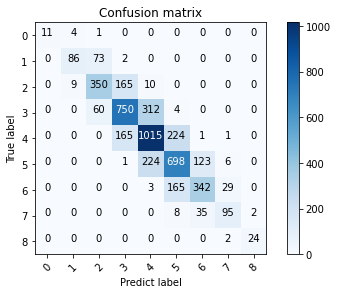

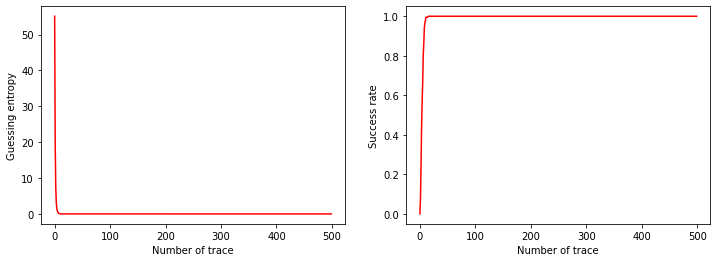

Result on target device:
Target test loss: 86.5601, Target test accuracy: 127/4500 (2.82%)



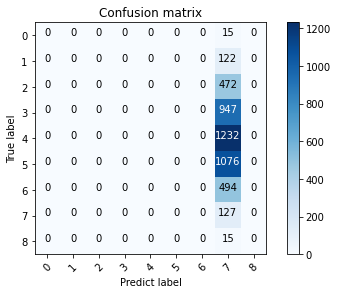

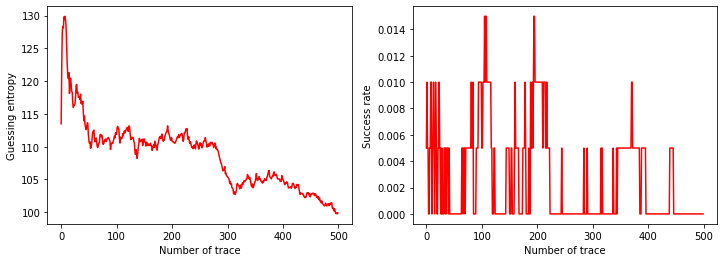

In [6]:
# create a network
model = ATN(num_classes=class_num)
print('Construct model complete')
if cuda:
    model.cuda()
    
# load the pre-trained network
checkpoint = torch.load('./models/pre-trained_device{}.pth'.format(source_device_id))
model_dict = checkpoint['model_state_dict']
model.load_state_dict(model_dict)
# evaluate the pre-trained model on source and target domain
with torch.no_grad():
    print('Result on source device:')
    test(model, source_device_id, model_flag='pretrained_source')
    print('Result on target device:')
    test(model, target_device_id, model_flag='pretrained_target')

## Adversarial Training

In [ ]:
# create a network
model = ATN(num_classes=class_num)
discriminator = Discriminator()
print('Construct model complete')
if cuda:
    model.cuda()
    discriminator.cuda()
# initialize a big enough loss
min_loss = 1000
# load the pre-trained network
checkpoint = torch.load('./models/pre-trained_device{}.pth'.format(source_device_id))
model_dict = checkpoint['model_state_dict']
model.load_state_dict(model_dict)
optimizer_critic = optim.SGD([
        {'params': discriminator.discriminator.parameters()},
    ], lr=lr, weight_decay=0.0005, momentum=0.9)
optimizer_model = optim.SGD([
        {'params': model.features.parameters()},
        {'params': model.classifier_1.parameters()},
        {'params': model.final_classifier.parameters()},
    ], lr=lr, weight_decay=0.0005, momentum=0.9)
# restore the optimizer state
for epoch in range(1, finetune_epoch + 1):
    print(f'Train Epoch {epoch}:')
    ALPA_train(epoch, model, discriminator)
    val_total_loss, val_tgt_loss, val_cls_loss = ALPA_validation(model, discriminator)
    if (val_total_loss < min_loss):
            min_loss = val_total_loss
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            }, './models/final_device{}_to_{}.pth'.format(source_device_id, target_device_id))

# Performance after Adversarial Training

Construct model complete
Result on source device:
Target test loss: 0.9280, Target test accuracy: 2976/5000 (59.52%)



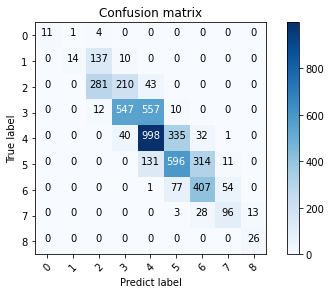

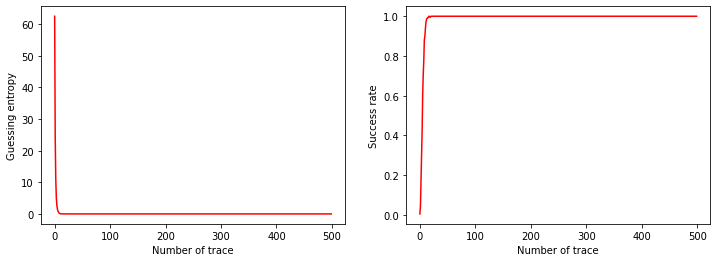

Result on target device:
Target test loss: 1.2154, Target test accuracy: 2285/4500 (50.78%)



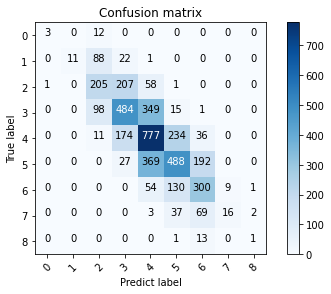

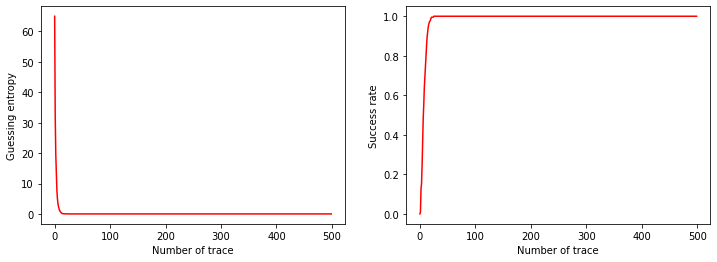

In [7]:
# create a network
model = ATN(num_classes=class_num)
print('Construct model complete')
if cuda:
    model.cuda()
# load the final network
checkpoint = torch.load('./models/final_device{}_to_{}.pth'.format(source_device_id, target_device_id))
model_dict = checkpoint['model_state_dict']
model.load_state_dict(model_dict)
# evaluate the final model on source and target domain
with torch.no_grad():
    print('Result on source device:')
    test(model, source_device_id, model_flag='final_source')
    print('Result on target device:')
    test(model, target_device_id, model_flag='final_target')